# Project 3

Import some libraries and the datasets

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv # because it is experimental we need this
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss, confusion_matrix, classification_report)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from IPython.display import Image, Markdown
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
import re

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv', quotechar="'")
data_index_2 = data_index_2.drop(columns=['Unnamed: 0'])
data_index_2.set_index(['Lon','Lat'])
# no idea what this is
#data_index_example = pd.read_csv('../Project_datasets/data_index - example.csv')
LPJ_GUESS_output = pd.read_csv('../Project_datasets/LPJ-GUESS_output_BERN1.csv')
# precipitation by day and statistics
Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')
Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')
# maximum temperature by day and statistics
Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')
Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')
# minimum temperature by day and statistics
Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')
Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')
# mean temperature by day and statistics
Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')
Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')
# shortwave radiation flux
Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')
Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')

Text file

In [3]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [4]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59191, 83)


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
0,-179.75,71.25,0.08,0.37,0.55,0.020,11.0,5.9,0.482,249.88,...,0.0,0.000,0.000,13,13,17,10,Russia,RUS,643
1,-179.75,68.75,0.20,0.48,0.32,0.031,17.0,6.3,0.753,250.64,...,0.0,0.003,0.015,13,11,17,10,Russia,RUS,643
2,-179.75,68.25,0.20,0.48,0.32,0.031,17.0,6.3,0.447,249.84,...,0.0,0.006,0.022,13,11,17,10,Russia,RUS,643
3,-179.75,67.75,0.20,0.48,0.32,0.031,17.0,6.3,0.526,250.84,...,0.0,0.002,0.020,13,11,17,10,Russia,RUS,643
4,-179.75,67.25,0.20,0.48,0.32,0.031,17.0,6.3,0.422,251.42,...,0.0,0.003,0.016,13,11,17,10,Russia,RUS,643


In [5]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

data information:
1. There are five climate variables which are daily average values during 1961-1990. They are Tswrf (Total shortwave radiation flux, W m-2), Pre (Precipitation, mm day-1), Tmp (Daily mean temperature, K), 
Tmax (Daily maximum temperature, K), and Tmin (Daily minimum temperature, K). 

2. In the file LPJ-GUESS_output BERN1.csv, the following variables are collected:
NPP: net primary productivity (kg C m-2 year-1)
SoilR: soil respiration (kg C m-2 year-1)
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)
VegC: Vegetation carbon poo (kg C m-2)l
LitterC: Litter carbon pool (kg C m-2)
SoilC: Soil carbon pool (kg C m-2)
Biome_Cmass: The biome type based on the maximum biomass (category)
Biome_LAI: The biome type based on the maximum LAI (category)
Biome_obs: The observed biome type (category)

3. legend of biome

4. soilmap_center_interpolated.dat: the texture inforamtion for each grid ce

### LPJ_Guess_output


In [6]:
print(f'shape: {LPJ_GUESS_output.shape}')
LPJ_GUESS_output.head()

shape: (59191, 12)


,Lon,Lat,NPP,SoilR,MaxBiomeCmax,MaxBiomeLAI,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs
0,39.75,-1.25,0.429,0.390,0.449,1.9821,1.225,0.758,5.941,8,12,12
1,150.25,-34.25,0.554,0.451,6.883,3.3174,6.953,3.221,10.566,7,7,6
2,-63.75,82.75,0.000,0.000,0.000,0.0000,0.000,0.003,0.002,13,13,17
3,59.25,30.75,0.043,0.042,0.090,0.2146,0.127,0.084,0.543,7,11,14
4,24.25,27.75,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,13,13,17


### Pred (Precipitation, mm day-1)
 

In [7]:
print(f'shape: {Predaymean.shape}')
Predaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,0.634400,0.838580,1.373300,1.487800,0.948640,0.705560,0.790570,0.69274,...,1.260600,1.011600,2.676200,2.146300,0.83299,0.97611,1.092800,2.015100,1.220200,1.064100
1,150.25,-34.25,3.176800,3.282800,4.271300,2.735100,3.118300,1.863200,2.245400,1.81270,...,1.243100,2.901500,1.580400,2.788500,3.62270,2.12350,2.546700,2.624700,1.521800,2.259400
2,-63.75,82.75,0.191720,0.553370,0.559100,0.350270,0.414340,0.239620,0.215600,0.39415,...,0.286600,0.187410,0.352480,0.303120,0.37439,0.29827,0.399200,0.162680,0.180370,0.251560
3,59.25,30.75,0.272920,0.576200,1.529900,0.475970,0.809060,0.772860,0.773340,0.12219,...,0.315400,0.223630,0.009584,0.004932,0.65535,1.25430,0.680690,0.534400,0.225750,0.281360
4,24.25,27.75,0.012822,0.044511,0.027133,0.003318,0.007306,0.014162,0.085964,0.01347,...,0.029099,0.040272,0.030631,0.000518,0.00058,0.12653,0.010889,0.002139,0.003662,0.009687


In [8]:
print(f'shape: {Predaymean_statistics.shape}')
Predaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,0.870380,0.693390,0.641700,1.622500,1.30490,1.11930,0.528780,0.450650,0.315910,2.049600,1.836000,1.289100
1,150.25,-34.25,3.251700,2.971600,1.559000,2.418500,2.07100,1.51770,1.725700,1.331900,1.054600,2.547500,2.358200,1.253600
2,-63.75,82.75,0.234270,0.209640,0.139210,0.333730,0.31885,0.18320,0.758070,0.735040,0.338730,0.325480,0.296160,0.154960
3,59.25,30.75,0.715820,0.592520,0.423350,0.136010,0.03079,0.17825,0.005847,0.000000,0.020282,0.180990,0.045619,0.278850
4,24.25,27.75,0.045284,0.015422,0.070006,0.061916,0.01050,0.10039,0.004480,0.000016,0.022542,0.028823,0.006414,0.055641


### Tmp (Daily mean temperature, K)

In [9]:
print(f'shape: {Tmpdaymean.shape}')
Tmpdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,301.11,301.14,301.07,300.95,301.14,301.32,301.33,301.33,...,301.49,301.63,301.19,301.11,301.15,301.39,301.33,301.40,301.49,301.39
1,150.25,-34.25,293.59,293.28,293.53,292.33,292.28,292.75,292.78,293.84,...,293.04,292.88,292.75,293.03,292.37,292.62,293.36,292.90,293.58,292.72
2,-63.75,82.75,241.33,242.18,242.51,241.94,241.99,241.18,240.35,240.29,...,242.67,243.21,244.22,243.65,242.88,241.99,243.01,243.91,244.09,243.10
3,59.25,30.75,281.13,281.06,281.34,282.07,281.57,281.56,282.13,282.14,...,283.05,282.85,282.33,281.68,281.74,281.59,281.69,281.00,281.42,281.48
4,24.25,27.75,285.84,285.50,285.25,285.06,284.62,285.04,285.01,284.48,...,285.96,285.78,285.66,285.68,285.39,285.57,285.62,285.71,285.71,285.66


In [10]:
print(f'shape: {Tmpdaymean_statistics.shape}')
Tmpdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,302.34,302.33,0.6554,301.21,301.20,1.3120,299.60,299.65,0.46193,301.42,301.39,0.44815
1,150.25,-34.25,292.82,292.97,1.1691,284.64,284.10,2.7774,282.29,281.50,1.80220,289.77,289.76,2.17460
2,-63.75,82.75,240.12,240.07,1.2096,260.31,261.44,10.1770,271.20,274.13,5.88880,247.77,245.76,4.80570
3,59.25,30.75,285.40,284.89,3.3975,299.63,300.13,4.0871,302.39,303.13,2.64690,288.71,287.35,4.84480
4,24.25,27.75,287.69,287.32,2.6203,299.53,299.15,2.9706,301.97,302.61,1.34370,291.17,290.75,4.37740


### Tmax

In [11]:
print(f'shape: {Tmaxdaymean.shape}')
Tmaxdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,302.63,302.91,302.83,302.43,302.76,302.99,302.95,303.04,...,302.96,303.14,302.65,302.49,302.66,302.87,302.73,302.76,302.99,302.98
1,150.25,-34.25,296.43,296.09,295.97,294.85,294.73,295.55,295.77,296.80,...,296.44,296.16,295.83,296.28,295.14,295.86,296.45,296.14,296.54,294.66
2,-63.75,82.75,244.72,245.60,245.89,245.11,244.98,244.50,243.61,243.90,...,246.04,246.82,247.53,247.26,246.58,246.02,246.67,247.49,247.69,246.57
3,59.25,30.75,284.75,284.92,285.61,286.23,285.53,285.78,286.21,285.91,...,287.97,288.04,287.38,286.80,287.24,287.00,286.86,286.56,286.61,286.65
4,24.25,27.75,290.05,289.76,289.50,289.10,289.05,289.41,289.26,288.84,...,290.04,289.73,289.58,289.62,289.48,289.77,289.97,290.24,290.17,289.90


In [12]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
Tmaxdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,304.27,304.43,0.74315,302.40,302.40,1.0318,301.13,301.11,0.39706,302.66,302.62,0.4142
1,150.25,-34.25,295.36,295.46,1.20660,288.11,287.64,3.0125,285.74,284.94,1.78200,293.06,293.14,2.1944
2,-63.75,82.75,243.87,243.72,1.14260,263.31,264.06,9.1992,272.13,274.69,5.69120,250.88,249.34,4.3383
3,59.25,30.75,288.82,287.81,3.27200,304.98,306.09,4.5394,307.99,308.63,2.57240,294.33,293.13,5.0202
4,24.25,27.75,291.96,291.66,2.65600,303.90,303.83,3.3008,306.28,306.87,1.23550,295.48,295.23,4.3877


### Tmin

In [13]:
print(f'shape: {Tmindaymean.shape}')
Tmindaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,296.63,296.49,296.55,296.51,296.69,296.64,296.68,296.74,...,296.54,296.48,296.30,296.23,296.26,296.29,296.46,296.43,296.55,296.83
1,150.25,-34.25,290.14,289.85,289.86,288.98,288.74,289.37,289.22,290.43,...,289.51,289.81,289.54,289.99,289.32,289.53,290.06,289.90,290.14,289.41
2,-63.75,82.75,240.80,241.47,241.86,241.37,241.49,240.74,239.82,239.64,...,241.86,242.46,243.48,242.96,242.10,241.31,242.23,243.03,242.98,242.13
3,59.25,30.75,278.46,278.36,278.70,279.43,279.03,279.01,279.38,279.36,...,278.97,278.82,278.43,278.07,277.74,277.97,277.98,277.51,277.71,277.86
4,24.25,27.75,284.46,283.98,283.83,283.46,283.21,283.67,283.66,283.15,...,284.47,284.35,284.12,284.14,283.96,284.09,284.21,284.29,284.28,284.57


In [14]:
print(f'shape: {Tmindaymean_statistics.shape}')
Tmindaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,298.06,298.41,0.85947,297.03,297.02,0.77132,295.42,295.38,0.19342,296.47,296.48,0.32203
1,150.25,-34.25,288.99,289.28,1.23520,280.58,280.14,2.60160,278.59,277.94,2.10780,286.79,287.04,2.03760
2,-63.75,82.75,239.70,239.61,1.13850,259.44,260.53,10.01100,268.84,272.09,5.76450,246.56,244.91,4.44050
3,59.25,30.75,282.46,281.83,3.41820,297.17,298.07,3.95480,299.81,300.63,2.58780,285.18,283.81,5.08320
4,24.25,27.75,285.68,285.31,2.18730,296.19,296.15,2.91960,298.87,299.31,1.03790,289.35,289.10,4.03760


### Tswrf (Total shortwave radiation flux, W m-2)

In [15]:
print(f'shape: {Tswrfdaymean.shape}')
Tswrfdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,231.59,219.87,236.62,238.73,239.37,250.71,236.94,236.88,...,205.60,223.60,195.67,198.74,203.09,193.82,210.05,199.19,223.03,220.83
1,150.25,-34.25,306.97,311.71,310.55,311.11,311.43,304.95,312.76,312.54,...,305.95,301.99,296.33,301.22,287.30,293.39,301.39,296.81,296.34,279.91
2,-63.75,82.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,59.25,30.75,133.78,137.99,136.90,126.10,145.59,132.06,136.92,132.72,...,145.09,125.97,127.70,125.30,137.31,113.15,117.91,131.45,134.91,128.61
4,24.25,27.75,144.89,153.19,155.81,165.83,163.23,163.97,153.20,162.64,...,144.84,150.68,153.20,151.03,158.60,153.69,153.10,160.78,152.35,146.26


In [16]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
Tswrfdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,245.3500,243.31,12.278,224.76,223.69,14.020,212.13,209.70,17.828,230.61000,233.69,13.8210
1,150.25,-34.25,273.2400,280.66,31.715,143.77,134.31,30.976,168.57,159.00,40.282,277.94000,279.75,26.3640
2,-63.75,82.75,6.8325,0.00,14.407,214.38,238.73,68.931,140.85,142.78,85.973,0.43718,0.00,1.5824
3,59.25,30.75,176.1900,170.71,37.004,312.30,323.65,34.345,286.04,287.80,31.122,160.32000,153.34,34.7040
4,24.25,27.75,207.9700,200.82,38.315,308.44,311.95,20.496,302.93,307.45,23.021,189.10000,185.46,32.6170


### County List and binome legend

In [17]:
# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

country_codes = pd.DataFrame(datatable, columns = ['Lon', 'Lat', 'GFED-region', 'Pan_2007', 'ISO3', 'UN'] )  
country_codes = country_codes.drop(index = 0)
country_codes.head()

,Lon,Lat,GFED-region,Pan_2007,ISO3,UN
1,-69.75,-55.25,5,Americas,CHL,152
2,-69.25,-55.25,5,Americas,CHL,152
3,-71.25,-54.75,5,Americas,CHL,152
4,-70.75,-54.75,5,Americas,CHL,152
5,-70.25,-54.75,5,Americas,CHL,152


In [18]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


 ## Some preparations

### number of samples of different biomes in different coutries

In [21]:
countrys_sample_size = data_index_2.groupby(['ISO3', 'Biome_obs']).size()   ##### NOT TESTED
#countrys_sample_size = pd.DataFrame(countrys_sample_size)
#countrys_sample_size.columns = [ "Size"]           # Maybe solve later
countrys_sample_size.head()

ISO3  Biome_obs
AGO   6              3
      8            187
      9             25
      10            88
      11             7
dtype: int64

In [22]:
# Samply size for countries
countrys_sample_size.at["EGY"]

Biome_obs
14     34
16     34
17    292
dtype: int64

### Plot and table generation

In [24]:
# Names my have to be improved
def df_to_latex(df, filename = 'mytable'):  
    s = df.style.to_latex(
    column_format="rrrrr", position="h", position_float="centering",
    hrules=True, label="table:5",
    multirow_align="t", multicol_align="r"
    )  
        
    with open('../Table/' + filename + '.tex', 'w') as f:
        f.write(s)  
    

In [25]:
## test
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                       age=[26, 45],
                       height=[181.23, 177.65]))

df_to_latex(df, filename = 'ATable')

In [26]:
def save_plot(figure, figurename = 'my_plot'):
    figure.savefig('../plots/' + figurename + '.pdf', bbox_inches='tight')

In [28]:
## test
#save_plot(fig, figurename ='worldmap')

### Plot function for statistics

In [30]:
def plot_statistics(data, name_data = 'data'):
    
    obs_data = "Biome_obs"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = obs_data)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    
    ## sample biomes
    obs_data = "Biome_obs_ISO3"
    fig, ax = plt.subplots(figsize = (8,4))
    ax = sns.countplot(data, x = 'ISO3', hue = 'Biome_obs')
    ax.tick_params(axis='x', rotation=90)
    save_plot(fig, figurename = 'countplot_' + name_data + '_' + obs_data)
    
    ## scatterplot biome_Cmax and biome_LAI
    obs_data = "Biome_obs_Biome_Cmax"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_Cmax", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)
    
    obs_data = "Biome_obs_Biome_LAI"
    fig, ax = plt.subplots(figsize = (4,4))
    ax = sns.scatterplot(data, x = "Biome_LAI", y = "Biome_obs")
    ax.set_yticks(range(1, 20,2))
    save_plot(fig, figurename = 'scatterplot_' + name_data + '_' + obs_data)

## Section 2: Visualisation


In [31]:
print(data_index_2.describe())

                Lon           Lat          clay          silt          sand  \
count  59191.000000  59191.000000  59191.000000  59191.000000  59191.000000   
mean      20.469932     30.797541      0.226424      0.280915      0.492662   
std       85.694107     31.484488      0.106558      0.109771      0.165724   
min     -179.750000    -55.250000      0.040000      0.050000      0.170000   
25%      -63.250000      7.750000      0.170000      0.200000      0.380000   
50%       30.250000     37.750000      0.230000      0.300000      0.450000   
75%       93.750000     57.250000      0.270000      0.330000      0.570000   
max      179.750000     83.250000      0.540000      0.610000      0.900000   

               orgC            CN            pH  cellfraction  \
count  59191.000000  59190.000000  59190.000000  59190.000000   
mean       0.022554     12.038250      6.329958      0.520901   
std        0.056028      2.444517      1.188566      0.167647   
min        0.002000      9.0

Countplot to count the number of data for each biom: 

Scatter plott - Biome_LAI: The biome type based on the maximum LAI (category)

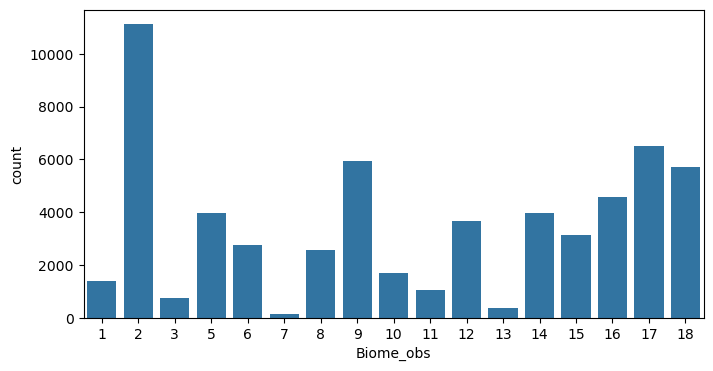

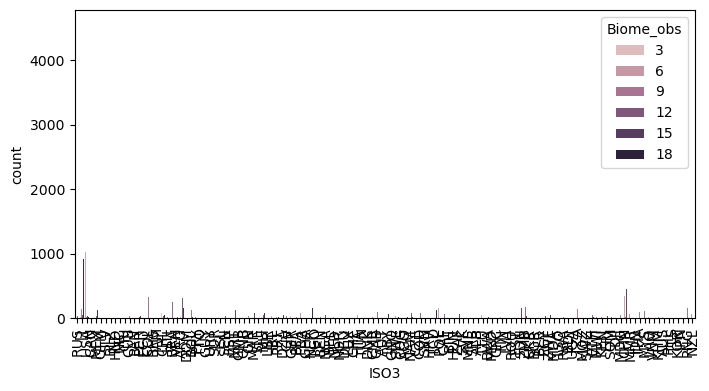

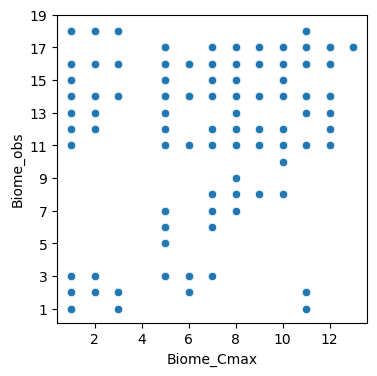

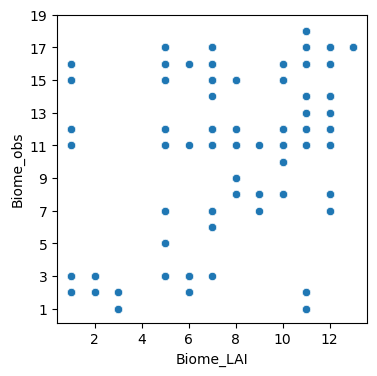

In [32]:
plot_statistics(data_index_2)

<Axes: xlabel='Lon', ylabel='Lat'>

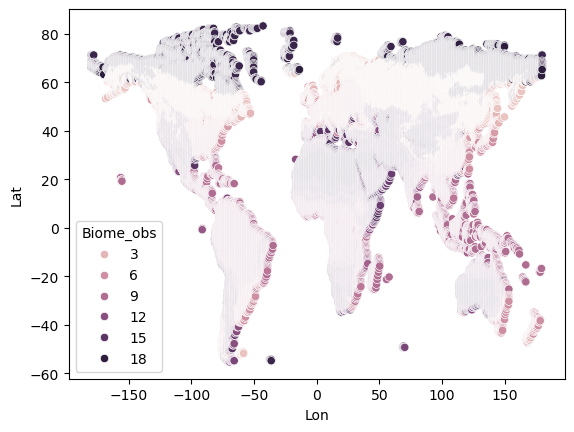

In [33]:
sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

## Section 3: Binary classification

We saw that `NaN` appeard somewhere in `data_index_2`. The following is to find out where it occurs.

In [41]:
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

['CN', 'pH', 'cellfraction']


,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,tmax_SpringMean,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
59182,179.75,71.25,0.08,0.37,0.55,0.02,NaN,NaN,NaN,249.45,...,0.0,0.0,0.001,13,13,17,0,[],[],0


Choose countries. Random.org gave us the biomes
- 17: desert
- 16: Arid shrub/steppe

In [42]:
biome_list_3 = [17,16] # our chosen biomes

Countplot: 

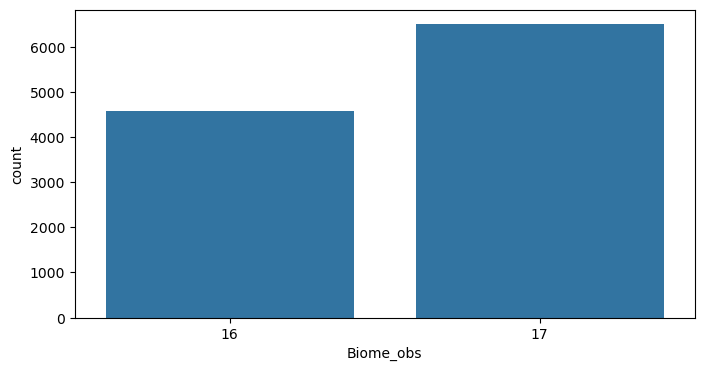

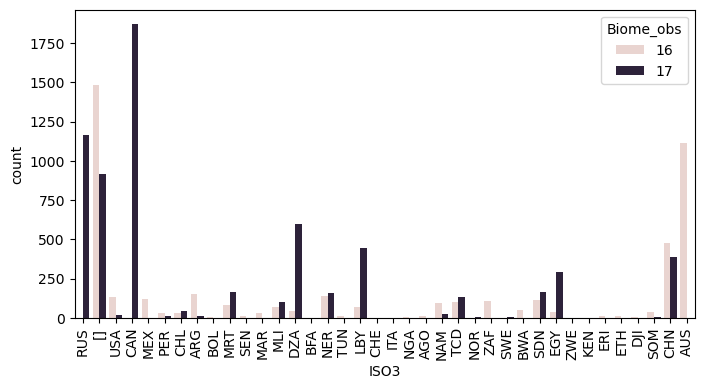

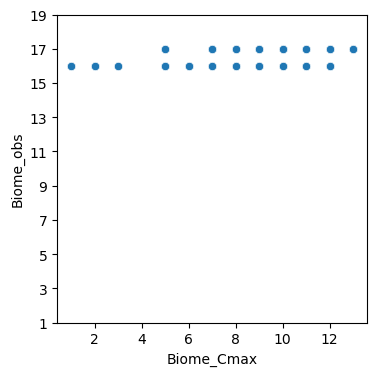

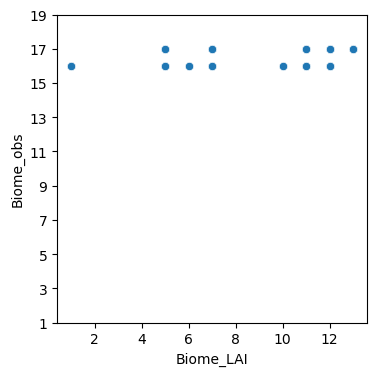

In [43]:
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list_3)]
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN

plot_statistics(relevant_data, name_data = 'relevant_data')

Thus we choose Egypt to train and China as test.

In [44]:
region_train_3 = data_index_2['ISO3'] == 'EGY' # egypt is the chosen one
region_test_3 = data_index_2['ISO3'] == 'CHN' # china is the chosen one

Here the action starts.

In [45]:
# the following function generates X_test, Y_test and X_train, Y_train for the binary classification
def model_create_XY(region_train, region_test, \
                     drop_columns=[], use_columns=None, \
                        objective='Biome_obs', objective_list=None, continuous_Y=False):
      
      drop_columns += [objective] # we would not want our objective to appear in the training data

      # restrict to two biomes, restrict to country codes, remove any rows with NaN
      relevant_data = data_index_2
      if not continuous_Y:
            if not objective_list: objective_list=list(data_index_2.loc[region_train][objective].drop_duplicates())
            relevant_data = relevant_data.loc[data_index_2[objective].isin(objective_list)] # restrict to given biomes
      relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN
      relevant_data_train = relevant_data.loc[region_train] # restrict to training country
      relevant_data_test = relevant_data.loc[region_test] # restrict to test country

      drop_columns += ['MaxBiomeLAI','Biome_obs','Biome_LAI','Biome_Cmax',
                       'Lon','Lat','Pan_2007','ISO3','UN','MaxBiomeCmax'] # drop these columns
      if use_columns:
            X_train = relevant_data_train[use_columns]
            X_test = relevant_data_test[use_columns]
      else:
            X_train = relevant_data_train.drop(columns=drop_columns)
            X_test = relevant_data_test.drop(columns=drop_columns)

      feature_names = list(X_train.columns)

      Y_train = relevant_data_train[objective]
      Y_test = relevant_data_test[objective]

      print(f"length of training data: {Y_train.shape[0]}")
      print(f"length of testing data: {Y_test.shape[0]}")

      return X_train, X_test, Y_train, Y_test, feature_names

Function for plotting (Permutation importance vs. purity importance)

In [46]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

def plot_permutation_importance_big_graph(clf, X_train, Y_train, feature_imp):

    mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    # tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    # tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X_train, Y_train, ax2)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importances on multicollinear features (train set)"
    )
    _ = fig.tight_layout()
    return fig

Binary classification model

In [58]:
# the following generates, trains and evaluates the model
def model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False):

    clf = RandomForestClassifier(random_state=0)
    
    if hyperparameter_tuning:
        X_hyper, Y_hyper = X_train, Y_train
        # X_hyper,_,Y_hyper,_ = skm.train_test_split(X_train, Y_train, train_size=300,random_state=0)
        # TODO: improve on this
        kfold3 = skm.KFold(3,
                        random_state=1,
                        shuffle=True) # let's try fewer fold to save running time

        fineness = 4 # determines how many parameters should be tested
        params = {
                'max_depth': np.linspace(5, 15, fineness).astype('int'),
                'n_estimators': np.linspace(10, 40, fineness).astype('int'), # CV number of trees, keep this low for part 4
                'min_samples_leaf': np.linspace(1, 5, fineness).astype('int'), # minimum leaf number
                }
        if False:
            rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3 )
        else:
            # Alternatively use HalvingGridSearchCV which is equally abismal in its performance
            rfc_gscv = HalvingGridSearchCV(clf, param_grid = params, scoring = "accuracy",
                                        cv = kfold3, min_resources=20, max_resources=30)
        
        # Fit the model
        model_rfc = rfc_gscv.fit(X_hyper, Y_hyper)

        # Model best estimator
        max_depths=model_rfc.best_estimator_.get_params()["max_depth"]
        max_trees= model_rfc.best_estimator_.get_params()["n_estimators"]
        min_samples_leaf= model_rfc.best_estimator_.get_params()["min_samples_leaf"]
        max_cvs= rfc_gscv.best_score_
        print("Max Depth: ", max_depths)
        print("Max Trees: ",max_trees)
        print("Min Leafs: ",min_samples_leaf)
        print("Max CV: ",max_cvs)

        clf = RandomForestClassifier(random_state=0, max_depth=max_depths, n_estimators=max_trees, min_samples_leaf=min_samples_leaf)

    clf.fit(X_train, Y_train)


    # Some performance 
    score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
    print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))
    kfold = skm.KFold(3, random_state=1, shuffle=True)
    # This becomes computationally quite expensive for large training sets
    scores_rfc_val = cross_val_score(clf, X_train, Y_train, cv=kfold)
    print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))
    score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
    print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))
    
    # confusion table
    display(Markdown('---\n The confusion table'))
    display(confusion_table(clf.predict(X_test),
                            Y_test))
    
    classreport = c(Y_test, clf.predict(X_test), zero_division = np.nan, output_dict=True)
    classreport = pd.DataFrame(classreport).transpose()
    display(classreport)
    
    # display importance table
    display(Markdown('---\n The feature importance'))
    feature_impo = clf.feature_importances_
    feature_imp = pd.DataFrame(
    {'importance':clf.feature_importances_},
    index=feature_names)
    display(feature_imp.sort_values(by='importance', ascending=False))
    
    
    # Plot Impurity-based vs. Permutation importance
    plot_permutation_importance_big_graph(clf, X_train, Y_train, feature_imp)
    
    display(Markdown('---'))

def regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning=False):
    reg = RandomForestRegressor()
    reg.fit(X_train, Y_train)

    score_reg_train = reg.score(X_train, Y_train)
    print('Accuracy of RandomForestRegressor on train data: {:.4f}'.format(score_reg_train))
    # The following takes way to long for large training sets
    # kfold = skm.KFold(3, random_state=1, shuffle=True)
    # scores_reg_val = cross_val_score(reg, X_train, Y_train, cv=kfold)
    # print("Accuracy RandomForestRegressor on cross validation: %0.4f ( %0.2f)" % (scores_reg_val.mean(), scores_reg_val.std()))
    score_reg_test = reg.score(X_test, Y_test)
    print('Accuracy of RandomForestRegressor on test data: {:.4f}'.format(score_reg_test))

    # MSE
    Y_hat = reg.predict(X_test)
    mse = np.mean((Y_test - Y_hat)**2)
    print(f'MSE for training data {mse}')

    ax = subplots(figsize=(8,8))[1]
    ax.scatter(Y_hat, Y_test)

In [59]:
# run the training data, test data and the model
def model_run(region_train, region_test, objective='Biome_obs', objective_list=None, \
                drop_columns=[], use_columns=None, \
                hyperparameter_tuning=False, continuous_Y=False):
    X_train, X_test, Y_train, Y_test, feature_names = model_create_XY(region_train, \
                        region_test, drop_columns, use_columns, objective, objective_list, continuous_Y)
    if continuous_Y:
        regression_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning)
    else:
        model_train_evaluate(X_train, X_test, Y_train, Y_test, feature_names, \
                         hyperparameter_tuning)

In [60]:
model_run(region_train_3, region_test_3, objective_list=biome_list_3)

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9632 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9850


---
 The confusion table

Truth,16,17
Predicted,,
16,477,12
17,1,377


NameError: name 'c' is not defined

Some evaluation of the model.

And now run the model whilst removing the medians

In [ ]:
features_median = [feature_name for feature_name in list(data_index_2) if feature_name[-6:]=='Median']
print(f'We dropped the features: {features_median}')

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_median)

Let's see how important the weather is.

In [51]:
features_weather = [feature_name for feature_name in list(data_index_2) if \
                   re.search('Fall|Summer|Winter|Spring',feature_name)]
print(f'We dropped the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, drop_columns=features_weather.copy())

We dropped the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9663 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.9931


---
 The confusion table

Truth,16,17
Predicted,,
16,477,5
17,1,384


,precision,recall,f1-score,support
16,0.989627,0.997908,0.993750,478.00000
17,0.997403,0.987147,0.992248,389.00000
accuracy,0.993080,0.993080,0.993080,0.99308
macro avg,0.993515,0.992527,0.992999,867.00000
weighted avg,0.993115,0.993080,0.993076,867.00000


---
 The feature importance

,importance
SoilR,0.318373
VegC,0.194957
NPP,0.183975
SoilC,0.078456
LitterC,0.076630
clay,0.036141
cellfraction,0.027651
sand,0.025204
pH,0.017084
silt,0.014798


---

Apparently not important at all. Now lets see if the model works only with weather data.

In [52]:
print(f'We only use the features: {features_weather}')
display(Markdown('---'))

model_run(region_train_3, region_test_3, objective_list=biome_list_3, use_columns=features_weather)

We only use the features: ['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMea

---

length of training data: 326
length of testing data: 867
Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy RandomForestClassifier on cross validation: 0.9509 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.5502


---
 The confusion table

Truth,16,17
Predicted,,
16,477,389
17,1,0


,precision,recall,f1-score,support
16,0.550808,0.997908,0.709821,478.000000
17,0.000000,0.000000,NaN,389.000000
accuracy,0.550173,0.550173,0.550173,0.550173
macro avg,0.275404,0.498954,0.709821,867.000000
weighted avg,0.303675,0.550173,0.709821,867.000000


---
 The feature importance

,importance
Pre_SpringMedian,0.071748
Pre_WinterMean,0.066330
tmin_FallMedian,0.055103
Pre_SpringMean,0.054281
Pre_WinterStd,0.053840
tmp_FallMean,0.048556
tmp_FallMedian,0.040753
tswrf_WinterMedian,0.038230
Pre_WinterMedian,0.037585
tmp_SummerMedian,0.036044


---

## Section 4: Multiclass classification

As regions we chose:
- China for training
- Africa for testing

In [53]:
region_train_4 = data_index_2['Pan_2007'] == 'China'
region_test_4 = data_index_2['Pan_2007'] == 'Africa'

And now we run the simulation

In [54]:
model_run(region_train_4, region_test_4, hyperparameter_tuning=True)

length of training data: 3775
length of testing data: 7871
Max Depth:  5
Max Trees:  40
Min Leafs:  2
Max CV:  0.5
Accuracy of RandomForestClassifier on train data: 0.8609
Accuracy RandomForestClassifier on cross validation: 0.8440 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.2291


---
 The confusion table

Truth,5,6,7,9,11,12,13,14,15,16,17
Predicted,,,,,,,,,,,
5,1,0,0,0,0,1,0,0,0,0,0
6,5,91,3,20,71,352,1,398,249,236,1281
7,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1368,148,224,4,323,235,178,309
11,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,15,567,0,486,192,615,335


,precision,recall,f1-score,support
5,0.500000,0.166667,0.250000,6.000000
6,0.033617,1.000000,0.065046,91.000000
7,NaN,0.000000,NaN,3.000000
9,0.490498,0.985591,0.655016,1388.000000
11,NaN,0.000000,NaN,234.000000
12,NaN,0.000000,NaN,1144.000000
13,NaN,0.000000,NaN,5.000000
14,NaN,0.000000,NaN,1213.000000
15,0.086878,0.284024,0.133056,676.000000
16,0.142857,0.001940,0.003828,1031.000000


---
 The feature importance

,importance
VegC,0.070366
SoilR,0.065603
NPP,0.058879
SoilC,0.054689
Pre_SummerMedian,0.052819
...,...
cellfraction,0.000038
sand,0.000004
silt,0.000000
pH,0.000000


---

This is relatively abysmal performance. Fiddling with the hyperparameters changes a lot though the
hyperparameter optimisation is far from optimal.

In [55]:
model_run(region_train_4, region_test_4, \
          hyperparameter_tuning=True, drop_columns=features_median)

length of training data: 3775
length of testing data: 7871
Max Depth:  5
Max Trees:  30
Min Leafs:  1
Max CV:  0.5555555555555555
Accuracy of RandomForestClassifier on train data: 0.8556
Accuracy RandomForestClassifier on cross validation: 0.8355 ( 0.01)
Accuracy of RandomForestClassifier on test data: 0.3977


---
 The confusion table

Truth,5,6,7,9,11,12,13,14,15,16,17
Predicted,,,,,,,,,,,
5,0,0,0,0,0,3,0,0,0,0,0
6,6,90,3,28,95,641,5,826,328,515,485
7,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1360,122,115,0,14,125,9,0
11,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0
15,0,1,0,0,17,385,0,327,223,485,56


,precision,recall,f1-score,support
5,0.000000,0.000000,NaN,6.000000
6,0.029782,0.989011,0.057822,91.000000
7,NaN,0.000000,NaN,3.000000
9,0.779370,0.979827,0.868177,1388.000000
11,NaN,0.000000,NaN,234.000000
12,NaN,0.000000,NaN,1144.000000
13,NaN,0.000000,NaN,5.000000
14,NaN,0.000000,NaN,1213.000000
15,0.149264,0.329882,0.205530,676.000000
16,0.127907,0.021339,0.036575,1031.000000


---
 The feature importance

,importance
SoilR,0.096636
tmin_SpringMean,0.079900
Pre_SummerMean,0.067639
tmp_SpringMean,0.065179
VegC,0.064579
SoilC,0.064398
NPP,0.063143
LitterC,0.041005
tmin_WinterMean,0.039032
tmp_WinterMean,0.037929


---

Let's see what happens if we remove the entire weather data.

In [56]:
model_run(region_train_4, region_test_4, \
          hyperparameter_tuning=True, drop_columns=features_weather)

length of training data: 3775
length of testing data: 7871
Max Depth:  5
Max Trees:  40
Min Leafs:  1
Max CV:  0.6666666666666666
Accuracy of RandomForestClassifier on train data: 0.8244
Accuracy RandomForestClassifier on cross validation: 0.8162 ( 0.00)
Accuracy of RandomForestClassifier on test data: 0.5269


---
 The confusion table

Truth,2,5,6,7,9,11,12,13,14,15,16,17
Predicted,,,,,,,,,,,,
2,0,6,17,1,146,7,33,0,23,10,0,0
5,0,0,5,1,35,21,57,1,25,34,0,0
6,0,0,69,1,198,206,366,4,36,448,1,0
7,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1009,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,2,0,0,0,0,0
13,0,0,0,0,0,0,0,0,2,0,0,0
14,0,0,0,0,0,0,39,0,349,3,161,21


,precision,recall,f1-score,support
2,0.000000,NaN,NaN,0.000000
5,0.000000,0.000000,NaN,6.000000
6,0.051919,0.758242,0.097183,91.000000
7,NaN,0.000000,NaN,3.000000
9,1.000000,0.726945,0.841886,1388.000000
11,NaN,0.000000,NaN,234.000000
12,1.000000,0.001748,0.003490,1144.000000
13,0.000000,0.000000,NaN,5.000000
14,0.609075,0.287716,0.390817,1213.000000
15,0.215797,0.226331,0.220939,676.000000


---
 The feature importance

,importance
VegC,0.200678
SoilR,0.156411
SoilC,0.132680
NPP,0.131125
LitterC,0.102457
orgC,0.079153
pH,0.070772
silt,0.057302
clay,0.030211
sand,0.022033


---

Wow, our performance just improved. Let's see what happens if we use only weather data.

In [57]:
print(features_weather)
model_run(region_train_4, region_test_4, \
          hyperparameter_tuning=True, use_columns=features_weather.copy())

['tmax_SpringMean', 'tmax_SpringMedian', 'tmax_SpringStd', 'tmax_SummerMean', 'tmax_SummerMedian', 'tmax_SummerStd', 'tmax_FallMean', 'tmax_FallMedian', 'tmax_FallStd', 'tmax_WinterMean', 'tmax_WinterMedian', 'tmax_WinterStd', 'tswrf_SpringMean', 'tswrf_SpringMedian', 'tswrf_SpringStd', 'tswrf_SummerMean', 'tswrf_SummerMedian', 'tswrf_SummerStd', 'tswrf_FallMean', 'tswrf_FallMedian', 'tswrf_FallStd', 'tswrf_WinterMean', 'tswrf_WinterMedian', 'tswrf_WinterStd', 'tmin_SpringMean', 'tmin_SpringMedian', 'tmin_SpringStd', 'tmin_SummerMean', 'tmin_SummerMedian', 'tmin_SummerStd', 'tmin_FallMean', 'tmin_FallMedian', 'tmin_FallStd', 'tmin_WinterMean', 'tmin_WinterMedian', 'tmin_WinterStd', 'tmp_SpringMean', 'tmp_SpringMedian', 'tmp_SpringStd', 'tmp_SummerMean', 'tmp_SummerMedian', 'tmp_SummerStd', 'tmp_FallMean', 'tmp_FallMedian', 'tmp_FallStd', 'tmp_WinterMean', 'tmp_WinterMedian', 'tmp_WinterStd', 'Pre_SpringMean', 'Pre_SpringMedian', 'Pre_SpringStd', 'Pre_SummerMean', 'Pre_SummerMedian', 'P

ValueError: 
All the 192 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._validate_data(
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\utils\validation.py", line 917, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\sklearn\utils\_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "C:\Users\annar\anaconda3\envs\RoutineEnvironment\lib\site-packages\pandas\core\generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'China'


Turns out the weather really does not play an important role. Let's see if the model works better at classifying 'Biome_Cmax'.

In [ ]:
model_run(region_train_4, region_test_4, objective='Biome_Cmax', hyperparameter_tuning=True)

Here we compare with LPJ-Guess.

## Section 5: Regression 

In this part we creatively use the same test and validation set as in part 4

In [ ]:
region_train_5 = region_train_4
region_test_5 = region_test_4

In [ ]:
model_run(region_train_5, region_test_5, objective='NPP', continuous_Y=True)